### Libraries and Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

In [2]:
#global variables
D=10 #how many lagged values to consider
tol_width=2 #suggested in paper is 5
window_size=8 #suggested value in the paper is 8
lower_bound_surprises=2 #suggested value in the paper is 2
activate_grid_search=0 #if set to 1 it will optimize the parameters for SVR

min_date_train='2018-04-01'
max_date_train='2018-06-07'
min_date_predict='2018-06-08'
max_date_predict='2018-06-30'

### Loading data

In [3]:
header = ["date","time","flow","anomaly"]
df = pd.read_csv('barreiro_ano.csv', sep=';', names=header)
holidays = pd.read_csv('holidays2018.csv',sep=';')
#df

In [4]:
df.dtypes

date        object
time        object
flow       float64
anomaly      int64
dtype: object

In [4]:
#convert column to date time
df['date'] = pd.to_datetime(df['date'])

In [5]:
# to extract all unique values (time) present in dataframe
time_unique_val=df.time.unique()
time_unique_val

array(['00:07:30', '00:22:30', '00:37:30', '00:52:30', '01:07:30',
       '01:22:30', '01:37:30', '01:52:30', '02:07:30', '02:22:30',
       '02:37:30', '02:52:30', '03:07:30', '03:22:30', '03:37:30',
       '03:52:30', '04:07:30', '04:22:30', '04:37:30', '04:52:30',
       '05:07:30', '05:22:30', '05:37:30', '05:52:30', '06:07:30',
       '06:22:30', '06:37:30', '06:52:30', '07:07:30', '07:22:30',
       '07:37:30', '07:52:30', '08:07:30', '08:22:30', '08:37:30',
       '08:52:30', '09:07:30', '09:22:30', '09:37:30', '09:52:30',
       '10:07:30', '10:22:30', '10:37:30', '10:52:30', '11:07:30',
       '11:22:30', '11:37:30', '11:52:30', '12:07:30', '12:22:30',
       '12:37:30', '12:52:30', '13:07:30', '13:22:30', '13:37:30',
       '13:52:30', '14:07:30', '14:22:30', '14:37:30', '14:52:30',
       '15:07:30', '15:22:30', '15:37:30', '15:52:30', '16:07:30',
       '16:22:30', '16:37:30', '16:52:30', '17:07:30', '17:22:30',
       '17:37:30', '17:52:30', '18:07:30', '18:22:30', '18:37:

In [6]:
# in order to accept time series with different periods per day
periods_per_day=len(time_unique_val)
periods_per_day

96

In [7]:
time_unique_ind=np.arange(periods_per_day)
time_unique_ind

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95])

In [8]:
#in order to have a mapping between the time of day and its index
time_unique=pd.DataFrame({'time':time_unique_val, 'time_unique_ind':time_unique_ind})
time_unique

,time,time_unique_ind
0,00:07:30,0
1,00:22:30,1
2,00:37:30,2
3,00:52:30,3
4,01:07:30,4
...,...,...
91,22:52:30,91
92,23:07:30,92
93,23:22:30,93
94,23:37:30,94


In [9]:
#creates a column with the time index
df['time_ind'] = df['time'].map(time_unique.set_index('time')['time_unique_ind'])
df.head()

,date,time,flow,anomaly,time_ind
0,2018-01-01,00:07:30,18.333067,0,0
1,2018-01-01,00:22:30,18.333067,0,1
2,2018-01-01,00:37:30,19.784872,0,2
3,2018-01-01,00:52:30,22.294744,0,3
4,2018-01-01,01:07:30,27.229756,0,4


In [10]:
#extra column indicating day of week
#0: mon, 1:tue, ..., 5:sat, 6:sun
df['dayofweek'] = pd.to_datetime(df['date'],dayfirst=True)
df['dayofweek'] = df['dayofweek'].dt.dayofweek
df.head()

,date,time,flow,anomaly,time_ind,dayofweek
0,2018-01-01,00:07:30,18.333067,0,0,0
1,2018-01-01,00:22:30,18.333067,0,1,0
2,2018-01-01,00:37:30,19.784872,0,2,0
3,2018-01-01,00:52:30,22.294744,0,3,0
4,2018-01-01,01:07:30,27.229756,0,4,0


In [11]:
holidays['date'] = pd.to_datetime(holidays['date'])
holidays.head()

,date
0,1970-01-01
1,1970-03-27
2,1970-03-29
3,1970-05-28
4,1970-05-10


In [12]:
# if day is a holiday, then dayofweek is -1
df.loc[df.date.isin(holidays.date), 'dayofweek'] = -1

In [13]:
#check if it worked
df[df.date=='2018-12-25']

,date,time,flow,anomaly,time_ind,dayofweek
34368,2018-12-25,00:07:30,17.262144,0,0,-1
34369,2018-12-25,00:22:30,16.214972,0,1,-1
34370,2018-12-25,00:37:30,17.899456,0,2,-1
34371,2018-12-25,00:52:30,18.460372,0,3,-1
34372,2018-12-25,01:07:30,18.859117,0,4,-1
...,...,...,...,...,...,...
34459,2018-12-25,22:52:30,20.637778,0,91,-1
34460,2018-12-25,23:07:30,16.250867,0,92,-1
34461,2018-12-25,23:22:30,15.554350,0,93,-1
34462,2018-12-25,23:37:30,15.301328,0,94,-1


## Lags of time series

### D previous readings

In [14]:
# in order to construct a new dataframe with D lagged values
df_lagged = df.copy()
number_lags = D # this is D (a global variable - check top of notebook)

for i in range(1, number_lags+1):
    shifted = df['flow'].shift(i)
    df_lagged = pd.concat((df_lagged, shifted), axis=1)

In [15]:
# just to label the columns of the resulting dataframe
lagged_cols=["n-"+ str(x) for x in range(1,number_lags+1)]
colnames= ["date","time","flow","anomaly", "time_ind","dayofweek"]+lagged_cols
df_lagged.columns=colnames
df_lagged.head()

,date,time,flow,anomaly,time_ind,dayofweek,n-1,n-2,n-3,n-4,n-5,n-6,n-7,n-8,n-9,n-10
0,2018-01-01,00:07:30,18.333067,0,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-01,00:22:30,18.333067,0,1,-1,18.333067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-01,00:37:30,19.784872,0,2,-1,18.333067,18.333067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-01,00:52:30,22.294744,0,3,-1,19.784872,18.333067,18.333067,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-01,01:07:30,27.229756,0,4,-1,22.294744,19.784872,18.333067,18.333067,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# in order to drop the rows corresponding do the first day
#to get rid of the NaN values

df_lagged =  df_lagged.iloc[periods_per_day:]
df_lagged.head()

,date,time,flow,anomaly,time_ind,dayofweek,n-1,n-2,n-3,n-4,n-5,n-6,n-7,n-8,n-9,n-10
96,2018-02-01,00:07:30,15.008750,0,0,3,16.586483,17.434139,17.016261,16.916267,16.770839,21.292067,22.624994,21.542819,22.036933,23.194106
97,2018-02-01,00:22:30,13.375950,0,1,3,15.008750,16.586483,17.434139,17.016261,16.916267,16.770839,21.292067,22.624994,21.542819,22.036933
98,2018-02-01,00:37:30,12.083542,0,2,3,13.375950,15.008750,16.586483,17.434139,17.016261,16.916267,16.770839,21.292067,22.624994,21.542819
99,2018-02-01,00:52:30,12.161200,0,3,3,12.083542,13.375950,15.008750,16.586483,17.434139,17.016261,16.916267,16.770839,21.292067,22.624994
100,2018-02-01,01:07:30,25.701713,0,4,3,12.161200,12.083542,13.375950,15.008750,16.586483,17.434139,17.016261,16.916267,16.770839,21.292067


In [17]:
#df_weekdays: contains data related to weekdays 
#df_sat: contains data related to saturdays
#df_sun: contains data related to sundays and holidays
df_weekdays = df_lagged[(df_lagged['dayofweek']>=0) & (df_lagged['dayofweek']<=4)]
df_sat = df_lagged[df_lagged['dayofweek']==5]
df_sun = df_lagged[(df_lagged['dayofweek']==-1) | (df_lagged['dayofweek']==6)]

## Create data

In [18]:
#get data to train a particular period (first of the day, eg)
'''
to create a dataframe that can be used to train a model
we should choose a range of dates (min_date, max_date)
a typeofdate ('weekdays', 'saturdays', 'sundays' (this one includes holidays))
and a period of the day (time_ind that can range from 0 to periods_per_day)
'''
def create_data_for_model(min_date, max_date, typeofday, time_ind):
    if typeofday=='weekdays':
        sel_data=df_weekdays[(df_weekdays.date>=min_date) & (df_weekdays.date<=max_date)]
    elif typeofday=='saturdays':
        sel_data=df_sat[(df_sat.date>=min_date) & (df_sat.date<=max_date)]
    else:
        sel_data=df_sun[(df_sun.date>=min_date) & (df_sun.date<=max_date)]
    sel_data=sel_data[sel_data['time_ind']==time_ind]
    return sel_data
 

In [19]:
#an example, just to test
data=create_data_for_model('2018-01-01', '2018-01-30', 'weekdays', 0)
#data

## GridSearchCV

In [20]:
# to look for the best SVR parameters
'''
to get the best set of parameters for the SVR model
'''
def grid_search(X,y):
    # SVR model
    model=svm.SVR()
    # dict of parameters
    parameters={'kernel':['rbf'], 'gamma':['auto','scale'], 'C':[0.1, 1, 10]} # 'epsilon':[0.01,0.05,0.5,1]
    # strategy to evaluate the performance of the cross-validated mode on the test set
    scorer=make_scorer(mean_squared_error, greater_is_better=False)
    # Build and fit the GridSearchCV
    grid = GridSearchCV(estimator=model, param_grid=parameters, scoring=scorer, cv=KFold(n_splits=5))
    grid_results = grid.fit(X, y)
    # in order to return the best set of parameters
    best_param=grid_results.cv_results_['params'][grid_results.best_index_]   
    return best_param

## SVR models

In [21]:
"""
data: dataframe containing data for a specific type of day and 
for a specific time_ind
"""
def svr_model(data,epsilon):
    y=data['flow'].copy()
    X=data.iloc[:,6:] #contains only the D previous values
    # 70% train, 30% test
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)
    if (activate_grid_search==1):
        params=grid_search(X,y)
        svr_model = svm.SVR(C=params['C'], epsilon=epsilon, gamma=params['gamma'], kernel=params['kernel'])
    else:
        svr_model = svm.SVR(C=10.0, epsilon=epsilon)
    svr_model.fit(X_train, y_train)
    return svr_model

In [22]:
#just for testing
#svr_model(data)

In [23]:
# creates a model for each period for weekdays
# for  a min_date-max_date range
# the result is a dataframe with as many rows as periods_per_day
# each containing a regressor
def creates_regressors_and_std_weekdays(min_date, max_date):
    regressors_weekdays = []
    std_weekdays=[]
    
    for i in range(periods_per_day):
        data=create_data_for_model(min_date, max_date, 'weekdays', i)
        std_weekdays.append(data['flow'].std())
        #epsilon=0.5
        epsilon=data['flow'].std()*0.5 #the tube
        regressors_weekdays.append(svr_model(data, epsilon))
    return regressors_weekdays,std_weekdays


In [24]:
# creates a model for each period for saturdays
# for  a min_date-max_date range
# the result is a dataframe with as many rows as periods_per_day
# each containing a regressor
def creates_regressors_and_std_saturdays(min_date, max_date):
    regressors_saturdays = []
    std_saturdays=[]
    
    for i in range(periods_per_day):
        data=create_data_for_model(min_date, max_date, 'saturdays', i)
        std_saturdays.append(data['flow'].std())
        #epsilon=0.5
        epsilon=data['flow'].std()*0.5
        regressors_saturdays.append(svr_model(data, epsilon))
    return regressors_saturdays, std_saturdays



In [25]:
# creates a model for each period for sundays and holidays
# for  a min_date-max_date range
# the result is a dataframe with as many rows as periods_per_day
# each containing a regressor
def creates_regressors_and_std_sundays(min_date, max_date):
    regressors_sundays = []
    std_sundays=[]
    
    for i in range(periods_per_day):
        data=create_data_for_model(min_date, max_date, 'sundays', i)
        std_sundays.append(data['flow'].std())
        epsilon=data['flow'].std()*0.5
        #epsilon=0.5
        regressors_sundays.append(svr_model(data,epsilon))
    return regressors_sundays, std_sundays

In [26]:
def predict_flow(df):
    predictions=[]
    for i in range(len(df)):
        if ((df.iloc[i,5]>=0) and (df.iloc[i,5] <=4)):
            model=regressors_weekdays[df.iloc[i,4]]
            predictions.append(model.predict(df.iloc[i:i+1,6:]))
        elif (df.iloc[i,5]==5): # i.e. saturdays
            model=regressors_saturdays[df.iloc[i,4]]
            predictions.append(model.predict(df.iloc[i:i+1,6:]))
        else: #i.e., sundays and holidays
            model=regressors_sundays[df.iloc[i,4]]
            predictions.append(model.predict(df.iloc[i:i+1,6:]))
      
    return predictions

            

In [27]:
# for testing, we will use min_date_train to max_date_train for
# constructing regressors
regressors_weekdays,std_weekdays=creates_regressors_and_std_weekdays(min_date_train, max_date_train)
regressors_saturdays,std_saturdays=creates_regressors_and_std_saturdays(min_date_train, max_date_train)
regressors_sundays, std_sundays=creates_regressors_and_std_weekdays(min_date_train, max_date_train)

In [28]:
df2predict=df_lagged[(df_lagged.date>=min_date_predict) & (df_lagged.date<=max_date_predict)]

In [29]:
y_true=df2predict['flow']
y_pred=predict_flow(df2predict)
y_pred=np.array(y_pred)


In [30]:
df_final=df2predict[['date','time_ind','dayofweek','flow','anomaly']]
df_final.insert(4,'forecast',y_pred)
df_final

,date,time_ind,dayofweek,flow,forecast,anomaly
15648,2018-06-13,0,2,18.771094,20.723152,0
15649,2018-06-13,1,2,21.083011,18.858365,0
15650,2018-06-13,2,2,17.107089,18.117789,0
15651,2018-06-13,3,2,18.516683,17.315519,0
15652,2018-06-13,4,2,18.493828,16.746089,0
...,...,...,...,...,...,...
32635,2018-06-12,91,1,19.240544,22.905165,0
32636,2018-06-12,92,1,17.913678,20.775816,0
32637,2018-06-12,93,1,15.907861,19.051290,0
32638,2018-06-12,94,1,16.196244,17.662266,0


In [31]:
# to choose what we want to plot in terms of forecast (number of days)
def plot_prediction(df2predict,number_days):   
    y_true=df2predict['flow']
    y_pred=predict_flow(df2predict)
    y_pred=np.array(y_pred)
    period_to_plot=periods_per_day*number_days
    
    yTrue=y_true[0:period_to_plot]
    yPred=y_pred[0:period_to_plot]
    
    period_len=24*60/periods_per_day #i.e., how many minutes per period
    string_xlabel= f"time (in periods of {period_len} min)"
    string_title=f"Comparing real and predicted values for {number_days} day(s) from {min_date_predict}"
    
    x = np.linspace(0,period_to_plot,period_to_plot) 
    
    plt.plot(x, yTrue, label='real value',color='blue')
    plt.plot(x, yPred, label='predicted with SVR',color='orange',linestyle='--')
    plt.xlabel(string_xlabel)
    plt.ylabel('Water flow ')
    plt.title(string_title)
    plt.legend()
    plt.show()
    
    # evaluation metrics
    error = mean_squared_error(yTrue, yPred)
    result= print('MSE from SVR: %.3f' % error)
    
    return result

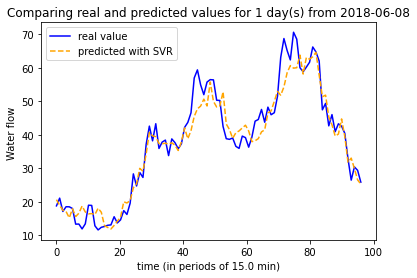

MSE from SVR: 19.038


In [32]:
# just to test
predict_1d=plot_prediction(df2predict, 1)

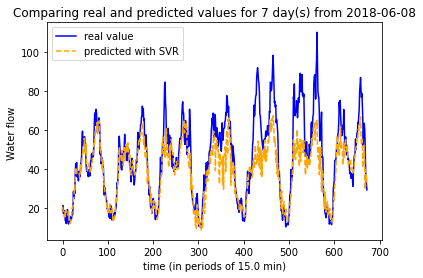

MSE from SVR: 151.921


In [33]:
predict_7d=plot_prediction(df2predict, 7)

## Anomaly detection

In [32]:
df_final.head()

,date,time_ind,dayofweek,flow,forecast,anomaly
15648,2018-06-13,0,2,18.771094,20.723152,0
15649,2018-06-13,1,2,21.083011,18.858365,0
15650,2018-06-13,2,2,17.107089,18.117789,0
15651,2018-06-13,3,2,18.516683,17.315519,0
15652,2018-06-13,4,2,18.493828,16.746089,0


In [33]:
'''A surprise occurs when the difference
between the observed and predicted value is greater
than 5 times the sd for that period of the day
This function creates a dataframe containing
date,  time, observed flow, predicted flow, a column indicating surprise
tol_width x std_deviation for each period for each type of day
paper suggests tol_width=5
'''
def detect_surprises(df_final, tol_width):
    df=df_final.copy()
    df["surprise"] = ""
    for i in range(len(df_final)):
        time_ind=df.iloc[i,1]
        dayofweek=df.iloc[i,2]
        observed=df.iloc[i,3]
        predicted=df.iloc[i,4]
        difference=abs(observed-predicted)
        if (dayofweek>=0) and (dayofweek <=4): #i.e., a weekday
            if difference>tol_width*std_weekdays[time_ind]:
                df.iloc[i,6]=1 
            else:
                df.iloc[i,6]=0
        elif (df.iloc[i,6]==5): # i.e. saturdays
            if difference>tol_width*std_saturdays[time_ind]:
                df.iloc[i,6]=1
            else:
                df.iloc[i,6]=0
        else: #i.e., sundays
            if difference>tol_width*std_sundays[time_ind]:
                df.iloc[i,6]=1
            else:
                df.iloc[i,6]=0
    return df

In [34]:
#tol_width is currently set as a global variable
#suggested value in paper is 5
df_surprises=detect_surprises(df_final,tol_width)
df_surprises

,date,time_ind,dayofweek,flow,forecast,anomaly,surprise
15648,2018-06-13,0,2,18.771094,20.723152,0,0
15649,2018-06-13,1,2,21.083011,18.858365,0,0
15650,2018-06-13,2,2,17.107089,18.117789,0,0
15651,2018-06-13,3,2,18.516683,17.315519,0,0
15652,2018-06-13,4,2,18.493828,16.746089,0,0
...,...,...,...,...,...,...,...
32635,2018-06-12,91,1,19.240544,22.905165,0,0
32636,2018-06-12,92,1,17.913678,20.775816,0,0
32637,2018-06-12,93,1,15.907861,19.051290,0,0
32638,2018-06-12,94,1,16.196244,17.662266,0,0


In [35]:
'''
from the dataframe with the detected surprises
we will slide a window of a certain window_size
(paper suggests a size of n=8)
and if in each window a number greater than the 
lower bound for suprises (paper suggests cubic root of n )
we classify the event as anomaly
'''
def detect_anomalies(df_surprises, window_size, lower_bound_surprises):
    df_surprises["detected_anomaly"] = 0
    for i in range(len(df_surprises)-window_size):
        sum=0
        #sliding window
        for j in range(window_size):
            sum+=df_surprises.iloc[i+j,6] #adds all surprises in window
        if sum>lower_bound_surprises:
            for j in range(window_size):
                if (df_surprises.iloc[i+j,6]==1):
                    df_surprises.iloc[i+j,7]=1 # surprises classified as anomalies
    return df_surprises

In [36]:
#window_size is a global variable, suggested value in paper is 8
#lower_bound_surprises is a global variable, suggested value in paper is 2
df = detect_anomalies(df_surprises, window_size, lower_bound_surprises)

In [37]:
#print detected anomalies
df[df['detected_anomaly']==1]

,date,time_ind,dayofweek,flow,forecast,anomaly,surprise,detected_anomaly
15872,2018-06-15,32,4,73.334022,43.189136,0,1,1
15873,2018-06-15,33,4,82.744456,47.714076,0,1,1
15874,2018-06-15,34,4,84.639928,44.998972,0,1,1
15993,2018-06-16,57,5,55.522544,31.470599,0,1,1
15995,2018-06-16,59,5,58.670250,27.890631,0,1,1
...,...,...,...,...,...,...,...,...
23903,2018-06-09,95,5,38.534956,23.508523,0,1,1
26756,2018-06-10,68,6,74.504406,49.614414,0,1,1
26757,2018-06-10,69,6,76.233122,50.028506,0,1,1
26758,2018-06-10,70,6,81.006977,52.488385,0,1,1


In [38]:
# where anomalies and detected anomalies coincide
df[(df['anomaly']==1) & (df['detected_anomaly']==1)]

,date,time_ind,dayofweek,flow,forecast,anomaly,surprise,detected_anomaly
16158,2018-06-18,30,0,75.320662,49.945350,1,1,1
16159,2018-06-18,31,0,83.694817,53.242059,1,1,1
16160,2018-06-18,32,0,67.253861,41.260855,1,1,1
16161,2018-06-18,33,0,70.381694,44.491153,1,1,1
16162,2018-06-18,34,0,68.781628,43.116669,1,1,1
16170,2018-06-18,42,0,77.283161,49.297410,1,1,1
16171,2018-06-18,43,0,87.428539,48.759821,1,1,1
16172,2018-06-18,44,0,89.163186,55.119919,1,1,1
16173,2018-06-18,45,0,86.622922,52.274292,1,1,1
16174,2018-06-18,46,0,79.576678,50.701962,1,1,1


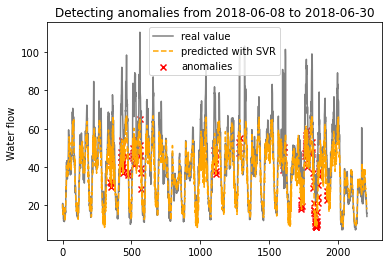

In [41]:

x = np.linspace(0,len(df),len(df)) 

anomalies_x =[]
anomalies_y=[]
  
for i in range(0, len(df)):
    if df.iloc[i,7]==1:#i.e., a detected anomaly
        anomalies_x.append(i)
        anomalies_y.append(df.iloc[i,4]) #predicted value

        
plt.plot(x, df['flow'], label='real value',color='grey')
plt.plot(x, df['forecast'], label='predicted with SVR',color='orange',linestyle='--')
plt.ylabel('Water flow ')

plt.scatter(anomalies_x, anomalies_y,marker='x', color='red', label='anomalies')
string_title=f"Detecting anomalies from {min_date_predict} to {max_date_predict}"
plt.title(string_title)
plt.legend()
plt.show()

### Evaluation metrics

In [40]:
pd.set_option('display.max_rows', 2208)

In [41]:
df.head(2208)

,date,time_ind,dayofweek,flow,forecast,anomaly,surprise,detected_anomaly
15648,2018-06-13,0,2,18.771094,20.723152,0,0,0
15649,2018-06-13,1,2,21.083011,18.858365,0,0,0
15650,2018-06-13,2,2,17.107089,18.117789,0,0,0
15651,2018-06-13,3,2,18.516683,17.315519,0,0,0
15652,2018-06-13,4,2,18.493828,16.746089,0,0,0
15653,2018-06-13,5,2,17.991072,16.586717,0,0,0
15654,2018-06-13,6,2,13.314219,17.004882,0,0,0
15655,2018-06-13,7,2,13.342272,17.045837,0,0,0
15656,2018-06-13,8,2,11.889172,16.981804,0,0,0
15657,2018-06-13,9,2,13.408472,16.502235,0,0,0


In [70]:
def evaluation(df):
    real_anomaly=len(df[df['anomaly']==1].index)
    detected_anomaly=len(df[df['detected_anomaly']==1].index)
    TP = len(df[(df['anomaly']==1) & (df['detected_anomaly']==1)].index)
    FP = len(df[(df['anomaly']==0) & (df['detected_anomaly']==1)].index)
    TN = len(df[(df['anomaly']==0) & (df['detected_anomaly']==0)].index)
    FN = len(df[(df['anomaly']==1) & (df['detected_anomaly']==0)].index)
    
    print('There are',real_anomaly,'occurrences of anomaly.')
    print(detected_anomaly, 'anomalies were detected.')
    print('Confusion Matrix')
    print('True Positives:', TP)
    print('False Positives:', FP)
    print('True Negatives:', TN)
    print('False Negatives:', FN)
    
    accuracy = (TP+TN)/(TP+TN+FN+FP)
    recall = TP/(TP+FN)
    precision=TP/(TP+FP)
    F1_score = (2*precision*recall)/(precision+recall)
    
    print('Model performance')
    print('Accuracy:',"%.2f" %accuracy)
    print('Recall:',"%.2f" %recall)
    print('Precision:',"%.2f" %precision)
    print('F1 score:',"%.2f" %F1_score)

In [71]:
evaluation(df)

There are 25 occurrences of anomaly.
95 anomalies were detected.
Confusion Matrix
True Positives: 16
False Positives: 79
True Negatives: 2104
False Negatives: 9
Model performance
Accuracy: 0.96
Recall: 0.64
Precision: 0.17
F1 score: 0.27


In [67]:
# racio acerto
#RA = detected_anomaly/real_anomaly
#RA

3.92

In [68]:
# racio não deteçoes -> falhas?
#RF = FN/real_anomaly
#RF

0.44